Due to the limitation of sympy, we can not simplify Summation notation when K is a symbol. So we define K as a fixed integer

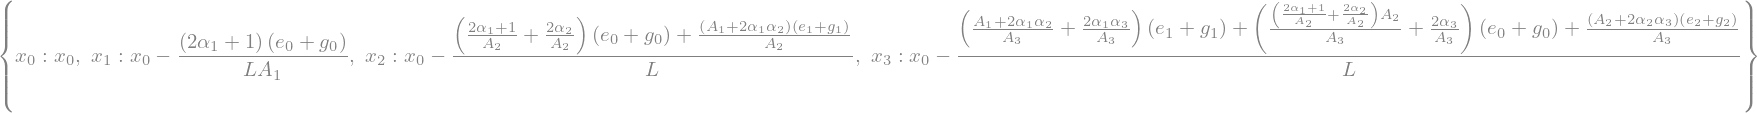

In [430]:
from sympy import *
import numpy as np

init_printing()

K = 3
i, j, k = symbols("i j k", integer=True)
L = symbols("L")
# K = symbols('K', integer=True, positive=True)
f = IndexedBase("f")
g = IndexedBase("g")
e = IndexedBase("e")
x = IndexedBase("x")
x0 = symbols("x0")
fs = symbols("f_*")
xs = symbols("x_*")

A = IndexedBase("A")
alpha = IndexedBase("alpha")

A_to_alpha = {A[-1]: 0, A[0]: 1, alpha[0]: 1, A[1]: 1 + alpha[1]}
for i in range(2, K + 1):
    A_to_alpha[A[i]] = A_to_alpha[A[i - 1]] + alpha[i]


# a_symbol = IndexedBase('alpha')
def calculate_theta(k, i):
    if i == k - 1:
        result = (2 * alpha[i] * alpha[k] + A[k - 1]) / A[k]
    elif i <= k - 2:
        result = 2 * alpha[k] * alpha[i] / A[k] + A[k - 1] / A[k] * calculate_theta(
            k - 1, i
        )
    else:
        result = 0
    return result.subs({A[0]: 1, A[-1]: 0, alpha[0]: 1})


theta = [[calculate_theta(k, i) for i in range(k)] for k in range(0, K + 1)]


def calculate_x(k):
    if k == 0:
        return x0
    else:
        return x0 - 1 / L * sum([theta[k][i] * (g[i] + e[i]) for i in range(k)])


x_expr = {x[k]: calculate_x(k) for k in range(K + 1)}
x_expr

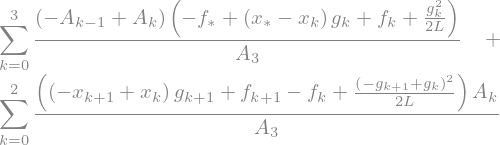

In [431]:
# initial inequality


def eq_vi(k):
    eq = (
        f[k + 1]
        - f[k]
        + g[k + 1] * (x[k] - x[k + 1])
        + 1 / (2 * L) * (g[k] - g[k + 1]) ** 2
    )
    return eq.subs(x_expr)


def eq_vs(k):
    eq = f[k] - fs + g[k] * (xs - x[k]) + 1 / (2 * L) * g[k] ** 2
    return eq.subs(x_expr)


ineq_init = Sum(A[k] / A[K] * eq_vi(k), (k, 0, K - 1)) + Sum(
    (A[k] - A[k - 1]) / A[K] * eq_vs(k), (k, 0, K)
)

# ineq_init = ineq_init.doit().subs({A[0]: 1, A[-1]: 0}).subs(x_expr).cancel()
ineq_init

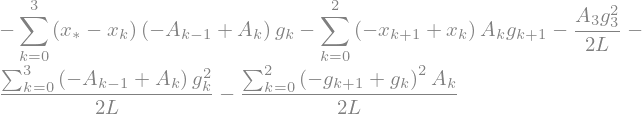

In [432]:
RHS_init = -A[K] * (ineq_init - (f[K] - fs - 1 / (2 * L) * g[K] ** 2))
RHS_1 = (
    -Sum(A[k] * g[k + 1] * (x[k] - x[k + 1]), (k, 0, K - 1))
    - Sum((A[k] - A[k - 1]) * g[k] * (xs - x[k]), (k, 0, K))
    - 1 / (2 * L) * Sum(A[k] * (g[k] - g[k + 1]) ** 2, (k, 0, K - 1))
    - 1 / (2 * L) * Sum((A[k] - A[k - 1]) * g[k] ** 2, (k, 0, K))
    - A[K] / (2 * L) * g[K] ** 2
)
RHS_1

In [433]:
res = RHS_1 - RHS_init
res.doit().cancel().subs(A_to_alpha)

In [434]:
RHS_1 = RHS_1.doit().subs(A_to_alpha).subs(x_expr).cancel()

double_sum = 0
for num_k in range(K):
    for num_i in range(num_k):
        double_sum += (
            1
            / L
            * (A[num_k + 1] * theta[num_k + 1][num_i] - A[num_k] * theta[num_k][num_i])
            * g[num_k + 1]
            * (g[num_i] + e[num_i])
        )
    double_sum += (
        1
        / L
        * A[num_k + 1]
        * theta[num_k + 1][num_k]
        * g[num_k + 1]
        * (g[num_k] + e[num_k])
    )


RHS_2 = (
    Sum(alpha[k] * g[k] * (x0 - xs), (k, 0, K))
    - 1 / L * Sum(A[k] * g[k] ** 2, (k, 0, K))
    + 1 / L * Sum(A[k] * g[k] * g[k + 1], (k, 0, K - 1))
    - double_sum
)

RHS_2 = RHS_2.doit().cancel()
res = RHS_2 - RHS_1
res.subs(A_to_alpha).cancel()
# res = RHS_1.subs(A_to_alpha) - RHS
# res.cancel()

In [435]:
double_sum = 0

for num_k in range(K):
    for num_i in range(num_k + 1):
        double_sum += (
            2
            / L
            * alpha[num_k + 1]
            * alpha[num_i]
            * g[num_k + 1]
            * (g[num_i] + e[num_i])
        )
    double_sum += 1 / L * A[num_k] * g[num_k + 1] * (g[num_k] + e[num_k])

RHS_a = (
    Sum(alpha[k] * g[k] * (x0 - xs), (k, 0, K))
    - 1 / L * Sum(A[k] * g[k] ** 2, (k, 0, K))
    + 1 / L * Sum(A[k] * g[k] * g[k + 1], (k, 0, K - 1))
    - double_sum
)

res = RHS_a.doit() - RHS_2
res.subs(A_to_alpha).cancel()

In [436]:
tau = symbols("tau", positive=True)
double_sum = 0
for num_k in range(K):
    for num_i in range(num_k + 1):
        double_sum += (
            2 / L * alpha[num_k + 1] * alpha[num_i] * g[num_k + 1] * (e[num_i])
        )
    double_sum += 1 / L * A[num_k] * g[num_k + 1] * e[num_k]

RHS_b = (
    -4 / L * (L / 4 * (x0 - xs) - Rational(1, 2) * Sum(alpha[k] * g[k], (k, 0, K))) ** 2
    + L / 4 * (x0 - xs) ** 2
    - Sum((A[k] - alpha[k] ** 2) / L * g[k] ** 2, (k, 1, K))
    - double_sum
)

res = RHS_b.doit() - RHS_a.doit()
res.subs(A_to_alpha).cancel()

In [437]:
# check for single k equation

k = 3
i = symbols("i")
RHS_0 = (
    -(A[k + 1] - alpha[k + 1] ** 2) / L * g[k + 1] ** 2
    - 2 / L * Sum(alpha[k + 1] * alpha[i] * g[k + 1] * e[i], (i, 0, k))
    - 1 / L * A[k] * g[k + 1] * e[k]
)

double_sum = 0
for num_i in range(k + 1):
    for num_j in range(num_i):
        double_sum += (
            2 * alpha[k + 1] ** 2 * alpha[num_i] * alpha[num_j] * e[num_i] * e[num_j]
        )
double_sum = double_sum / (L * (A[k + 1] - alpha[k + 1] ** 2))
RHS_1 = (
    -1
    / (L * (A[k + 1] - alpha[k + 1] ** 2))
    * (
        (A[k + 1] - alpha[k + 1] ** 2) * g[k + 1]
        + Sum(alpha[k + 1] * alpha[i] * e[i], (i, 0, k))
        + Rational(1, 2) * A[k] * e[k]
    )
    ** 2
    + 1
    / (L * (A[k + 1] - alpha[k + 1] ** 2))
    * Sum(alpha[k + 1] ** 2 * alpha[i] ** 2 * e[i] ** 2, (i, 0, k - 1))
    + double_sum
    + 1
    / (L * (A[k + 1] - alpha[k + 1] ** 2))
    * Sum(alpha[k + 1] * alpha[i] * A[k] * e[i] * e[k], (i, 0, k - 1))
    + (2 * alpha[k + 1] * alpha[k] + A[k]) ** 2
    / (4 * L * (A[k + 1] - alpha[k + 1] ** 2))
    * e[k] ** 2
)

res = RHS_1 - RHS_0
res.doit().cancel()

In [438]:
# check the left terms in e equations

k = symbols("k")


# check e[k]**2 terms


RHS_ek_0 = Sum(
    (2 * alpha[k + 1] * alpha[k] + A[k]) ** 2
    / (4 * L * (A[k + 1] - alpha[k + 1] ** 2))
    * e[k] ** 2,
    (k, 0, K - 1),
)

for num_k in range(K):
    RHS_ek_0 += Sum(
        alpha[num_k + 1] ** 2
        * alpha[i] ** 2
        * e[i] ** 2
        / (L * (A[num_k + 1] - alpha[num_k + 1] ** 2)),
        (i, 0, num_k - 1),
    )

RHS_ek_0.doit()

RHS_ek_1 = Sum(
    (2 * alpha[k + 1] * alpha[k] + A[k]) ** 2
    / (4 * L * (A[k + 1] - alpha[k + 1] ** 2))
    * e[k] ** 2,
    (k, 0, K - 1),
)

for num_k in range(K):
    RHS_ek_1 += Sum(
        alpha[num_k] ** 2
        * alpha[j + 1] ** 2
        * e[num_k] ** 2
        / (L * (A[j + 1] - alpha[j + 1] ** 2)),
        (j, num_k + 1, K - 1),
    )
res_ek = RHS_ek_0 - RHS_ek_1
res_ek.doit().cancel()

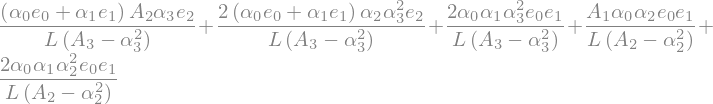

In [439]:
## check e[k]*e[i] terms
j = symbols("j")
RHS_eki_0 = 0

for num_k in range(K):
    RHS_eki_0 += Sum(
        alpha[num_k + 1] * alpha[i] * A[num_k] * e[i] * e[num_k], (i, 0, num_k - 1)
    ) / (L * (A[num_k + 1] - alpha[num_k + 1] ** 2))

    for num_i in range(num_k + 1):
        RHS_eki_0 += Sum(
            2
            * alpha[num_k + 1] ** 2
            * alpha[num_i]
            * alpha[j]
            * e[num_i]
            * e[j]
            / (L * (A[num_k + 1] - alpha[num_k + 1] ** 2)),
            (j, 0, num_i - 1),
        )

RHS_eki_0.doit()

In [440]:
RHS_eki_1 = 0

for num_k in range(K):
    for num_i in range(num_k):
        RHS_eki_1 += (
            alpha[num_k + 1]
            * alpha[num_i]
            * (A[num_k] + 2 * alpha[num_k + 1] * alpha[num_k])
            / (L * (A[num_k + 1] - alpha[num_k + 1] ** 2))
            * e[num_k]
            * e[num_i]
        )
    for num_i in range(0, num_k):
        for num_j in range(num_k + 1, K):
            RHS_eki_1 += (
                2
                * alpha[num_j + 1] ** 2
                * alpha[num_k]
                * alpha[num_i]
                / (L * (A[num_j + 1] - alpha[num_j + 1] ** 2))
                * e[num_k]
                * e[num_i]
            )


res = RHS_eki_0 - RHS_eki_1
res.doit().subs(alpha[0], 1).cancel()

In [441]:
## For P_k,i notation

P = IndexedBase("P")

eq0 = Sum(P[k, k] * e[k] ** 2, (k, 0, K - 1))
for num_k in range(K):
    eq0 += Sum(P[num_k, i] * e[num_k] * e[i], (i, 0, num_k - 1))
eq0.doit().cancel()

In [442]:
eq1 = Sum(P[k, k] * e[k] ** 2, (k, 0, K - 1))
for num_k in range(K):
    eq1 += -Sum(Rational(1,2)*P[num_k,i] * (e[num_k]-e[i])**2 ,(i,0,num_k-1))
    eq1 += Sum(Rational(1,2)*P[num_k,i] *e[num_k]**2  ,(i,0,num_k-1))
    eq1 += Sum(Rational(1,2) * P[i,num_k]*e[num_k]**2 ,(i,num_k+1,K-1))
eq1.doit().cancel()

res = eq0 - eq1
res.doit().cancel()

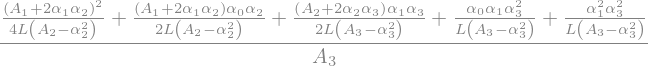

In [443]:
# Compare to u expression
def P_func(k,i):
    if i==k:
        P = (2 * alpha[k+1]*alpha[k]+A[k])**2 / (4*L*(A[k+1]-alpha[k+1]**2)) 
        for j in range(k+1,K):
            P += alpha[j+1]**2 * alpha[k] **2 / (L*(A[j+1]-alpha[j+1]**2))
    else:
        P = alpha[k+1]*alpha[i]*(A[k]+2*alpha[k+1]*alpha[k])/(L*(A[k+1]-alpha[k+1]**2))
        for j in range(k+1,K):
            P+= 2*alpha[j+1]**2*alpha[k]*alpha[i]/(L*(A[j+1]-alpha[j+1]**2))


    return P
def u_func_P(k):
    u = P_func(k,k)
    for i in range(k):
        u+= Rational(1,2)*P_func(k,i)
    for i in range(k+1,K):
        u+= Rational(1,2)*P_func(i,k)
    return u/A[K]

u_func_P(1)

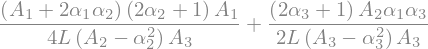

In [444]:
def u_expr(i):
    
    u = (
            A[i]
            * (1 + 2 * alpha[i + 1])
            * (A[i] + 2 * alpha[i] * alpha[i + 1])
            / (4 * L * A[K] * (A[i + 1] - alpha[i + 1] ** 2))
        )
    for k in range(i + 1, K):
        u = u + A[k] * (1 + 2 * alpha[k + 1]) * alpha[i] * alpha[k + 1] / (
                2 * L * A[K] * (A[k + 1] - alpha[k + 1] ** 2)
            )
    return u
u_expr(1)

In [447]:
res = u_func_P(0) - u_expr(0)
res.subs(A_to_alpha).cancel()